In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image
from skimage import measure
from tifffile import imsave
from scipy.signal import savgol_filter

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf
import preprocess as pp

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
def normalize_uint8_(arr, max_val=None):
    arr -= arr.min()
    arr /= arr.max()
    return (arr * 255).astype(np.uint8)
    # return (arr * 127).astype(np.uint8)
#     return arr

# normalize_uint8_(stacked_df)

In [4]:
# base_path = "/mnt/Data/prerna_velocity/2021_09_29/"
base_path = "/mnt/Data/prerna_velocity/2021_09_29_processed_4x4/"
control_fname = base_path + "scan2_DD_control_200um_20210929.tif"
blockers_fname = base_path + "scan2_DD_blockers_200um_20210929.tif"

control = io.imread(os.path.join(base_path, control_fname))
blockers = io.imread(os.path.join(base_path, blockers_fname))
stacked = np.concatenate([control, blockers], axis=0)
stacks = {"control": control, "blockers": blockers}
clipped = np.clip(stacked, stacked.min(), 40000)

# baseline frames post laser
bsln_start = 90
bsln_end = 200
stacks_df = {
    cond: (
        (r - np.mean(r[bsln_start:bsln_end], axis=0))
        / np.mean(r[bsln_start:bsln_end], axis=0)
    )
    for cond, r in stacks.items()
}
stacked_df = np.concatenate(list(stacks_df.values()), axis=0)
subtracted_df = stacks_df["control"] - stacks_df["blockers"]
clipped_df = np.clip(stacked_df, stacked_df.min(), 3.)

dt = 1 / 58.2487
recs_xaxis = np.arange(control.shape[0]) * dt
stacked_xaxis = np.arange(stacked.shape[0]) * dt
n_frames, y_sz, x_sz = control.shape

save_tiff(os.path.join(base_path, "stacked"), "stacked.tif", stacked)
save_tiff(os.path.join(base_path, "stacked_df"), "stacked_df.tif", stacked_df)

loaded_df = io.imread(os.path.join(base_path, "stacked_df", "stacked_df.tif"))
loaded_gif = load_gif(
    os.path.join(base_path, "stacked_df", "s2p", "stacked_df_denoised.gif"))

# TODO: add function for extraction of beams using the masks from s2p, and a function
# using that to do denoised movies using data that has not passed through s2p. I don't
# know for sure what scaling is happening to the data.
denoised = s2p_hdf_to_roi_movie(
    os.path.join(base_path, "stacked_df", "s2p", "stacked_df.h5"))

print("control shape:", control.shape)
print("blockers shape:", blockers.shape)
print("stacked shape:", stacked.shape)

control shape: (450, 64, 64)
blockers shape: (450, 64, 64)
stacked shape: (900, 64, 64)


In [5]:
with h5.File(os.path.join(base_path, "stacked_df", "s2p", "stacked_df.h5")) as f:
    stacked_df_s2p = unpack_hdf(f)
    
roi_beams = pixels_to_beams(clipped_df, stacked_df_s2p["pixels"])
# filtered_beams = np.stack([savgol_filter(r, 51, 2) for r in roi_beams], axis=0)
filtered_beams = rolling_average(roi_beams, n=31, axis=1)

raw_denoised = beams_to_movie(
    roi_beams, stacked_df_s2p["pixels"], stacked_df_s2p["space_dims"])
filtered_denoised = beams_to_movie(
    filtered_beams, stacked_df_s2p["pixels"], stacked_df_s2p["space_dims"])

flat_roi_beams = pixels_to_beams(stacked_df, stacked_df_s2p["pixels"], use_weights=False)
raw_flat_denoised = beams_to_movie(
    flat_roi_beams, stacked_df_s2p["pixels"], stacked_df_s2p["space_dims"])

In [6]:
roi_beams.shape

(123, 900)

In [7]:
if True:
    array_to_mp4(
        filtered_denoised, 
        os.path.join(base_path, "denoised_movie.mp4"), 
        fps=(1 / dt),
        scale=10
    )

<IPython.core.display.Javascript object>


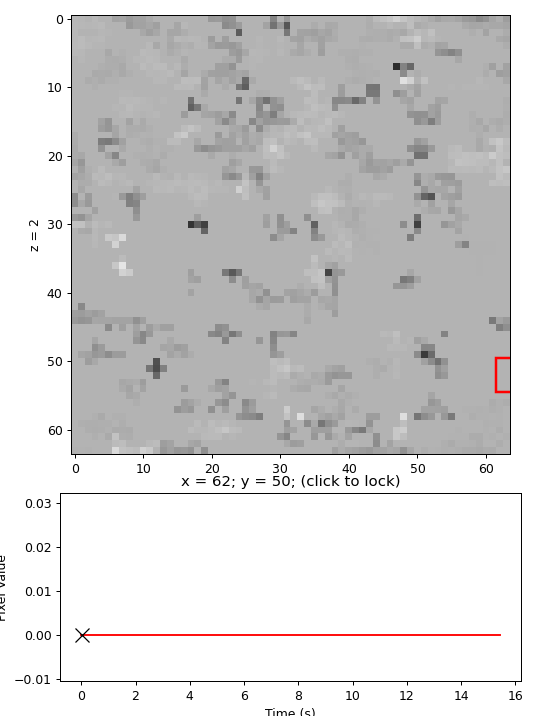

Movie shape: (900, 64, 64)


In [8]:
movie_plot = StackExplorer(
#     stacked,
#     stacked_df,
#     loaded_df,
#     loaded_gif,
#     denoised,
#     raw_denoised,
#     norm_denoised,
    filtered_denoised,
#     normalize_uint8_(stacked_df),
    zaxis=stacked_xaxis,
    delta=1,
    roi_sz=5,
#     vmin=-0.5,
    figsize=(6, 8)
)
movie_plot.ax[1].set_xlabel("Time (s)")
movie_plot.ax[1].set_ylabel("Pixel Value")

print("Movie shape:", stacked.shape)
movie_plot.fig.show()

<IPython.core.display.Javascript object>


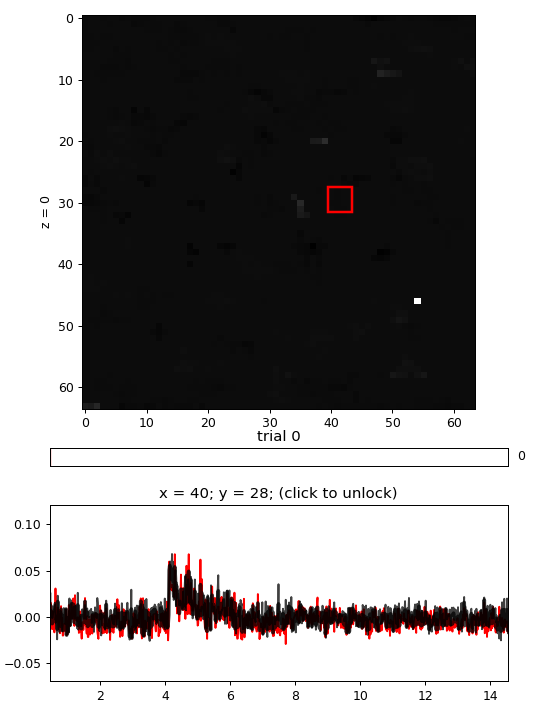

Movie shape: (900, 64, 64)


In [19]:
s2p_vs_raw_df = StackExplorer(
    np.stack([denoised, raw_denoised], axis=0),
    zaxis=stacked_xaxis,
    delta=1,
    roi_sz=4,
#     vmin=-0.5,
    figsize=(6, 8)
)
movie_plot.ax[1].set_xlabel("Time (s)")
movie_plot.ax[1].set_ylabel("Pixel Value")

print("Movie shape:", stacked.shape)
movie_plot.fig.show()

<IPython.core.display.Javascript object>


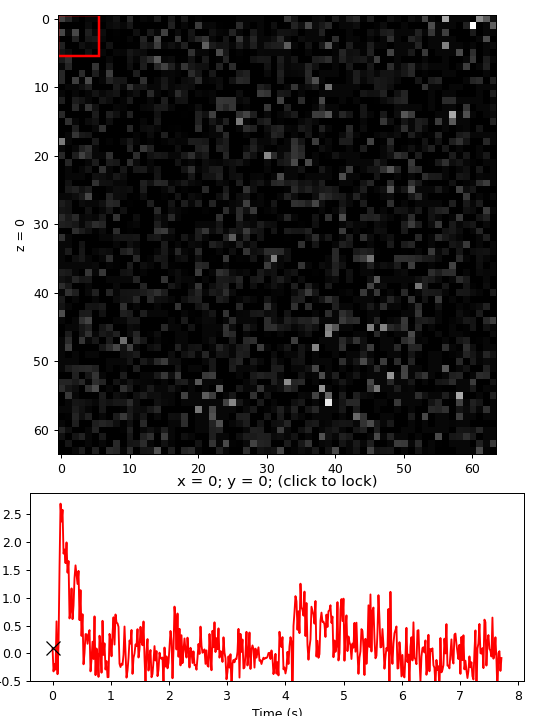

In [9]:
subtracted_plot = StackExplorer(
    subtracted_df,
    zaxis=recs_xaxis,
    delta=1,
    roi_sz=6,
    vmin=-0.5,
    figsize=(6, 8)
)
subtracted_plot.ax[1].set_xlabel("Time (s)")
subtracted_plot.ax[1].set_ylabel("Pixel Value")

subtracted_plot.fig.show()

TODO:
- still need to try generated glusnfr quanta release variance with rates generated from different QSEs (get an estimate of QSE based on the variance of the sustained phase of poisson quantal sums)

### Temporal projections of pre and post blocker application.
Laser response is skipped over for mean and variance calculations. 
* variance seems to track with changes in the mean over space
* left side appears to be "down" and right side "up" in blockers, relative to control

<IPython.core.display.Javascript object>


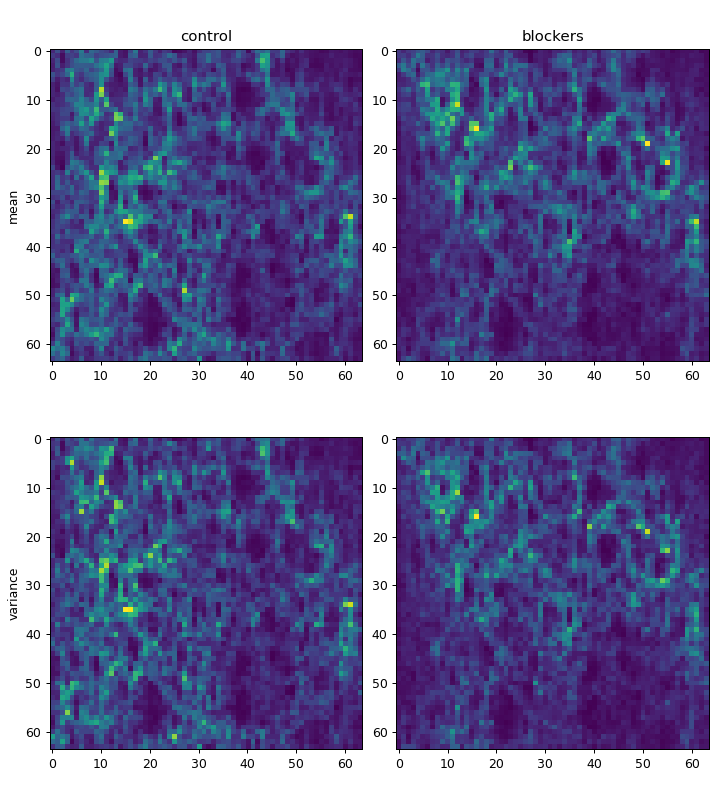

In [10]:

control_proj = np.mean(control[bsln_start:bsln_end], axis=0) 
blockers_proj = np.mean(blockers[bsln_start:bsln_end], axis=0)
mean_projs = {"control": control_proj, "blockers": blockers_proj}

projections_fig, projections_ax = plt.subplots(2, 2, figsize=(9, 10))
projections_ax[0][0].imshow(control_proj)
projections_ax[0][1].imshow(blockers_proj)
projections_ax[1][0].imshow(np.var(control[bsln_start:bsln_end], axis=0))
projections_ax[1][1].imshow(np.var(blockers[bsln_start:bsln_end], axis=0))
projections_ax[0][0].set_title("control")
projections_ax[0][1].set_title("blockers")
projections_ax[0][0].set_ylabel("mean")
projections_ax[1][0].set_ylabel("variance")

projections_fig.tight_layout()
projections_fig.show()

### Grid ROI placement

In [11]:
grid_w = 8
grid_h = 8
edge_cut = 0
bsln_start = 90
bsln_end = 200

grid_recs, grid_locs, grid_vars, grid_means = [{} for _ in range(4)]
for cond, rec in stacks.items():
    recs, locs, means, vars = [[] for _ in range(4)]
    for y0 in range(0, y_sz, grid_h):
        for x0 in range(edge_cut, x_sz - edge_cut, grid_w):
            beam = np.mean(rec[:, y0:y0 + grid_h, x0:x0 + grid_w], axis=(1, 2))
            recs.append(beam)
            means.append(np.mean(beam[bsln_start:bsln_end]))
            vars.append(np.var(beam[bsln_start:bsln_end]))
            locs.append([x0, y0])        
    grid_recs[cond] = np.stack(recs, axis=0)
    grid_means[cond] = np.array(means)
    grid_vars[cond] = np.array(vars)
    grid_locs[cond] = np.stack(locs, axis=0)

### Quantal Size estimates

<IPython.core.display.Javascript object>


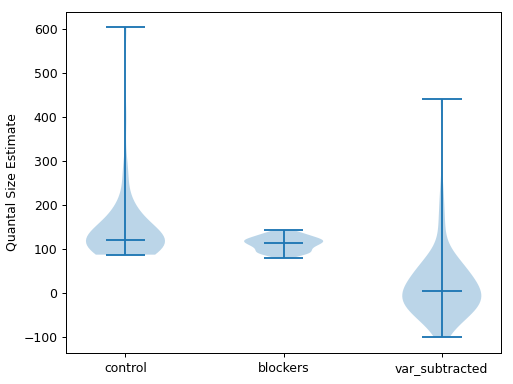

average control QSE: 145.4183859716398
average blockers '''QSE''': 112.2561297051542
average variance subracted QSE: 18.94545504785157
median variance subracted QSE: 3.7271683561956146


In [12]:
baseline_qses = {
    c: (
        2.0 * np.var(r[:, bsln_start:bsln_end], axis=1) 
        / (np.mean(r[:, bsln_start:bsln_end], axis=1))
    )
    for c, r in grid_recs.items()
}

baseline_qses["var_subtracted"] = (
    2.0 
    * (np.var(grid_recs["control"][:, bsln_start:bsln_end], axis=1) 
       - np.var(grid_recs["blockers"][:, bsln_start:bsln_end], axis=1))
    / np.mean(grid_recs["control"][:, bsln_start:bsln_end], axis=1)
)

qse_violin_fig, qse_violin_ax = plt.subplots(1)
qse_violin_ax.violinplot(list(baseline_qses.values()), showmedians=True)
qse_violin_ax.set_xticks([i + 1 for i in range(len(baseline_qses))])
qse_violin_ax.set_xticklabels(list(baseline_qses.keys()))
qse_violin_ax.set_ylabel("Quantal Size Estimate")

qse_violin_fig.tight_layout()

print("average control QSE:", np.mean(baseline_qses["control"]))
print("average blockers '''QSE''':", np.mean(baseline_qses["blockers"]))
print("average variance subracted QSE:", np.mean(baseline_qses["var_subtracted"]))
print("median variance subracted QSE:", np.median(baseline_qses["var_subtracted"]))

### Grid ROIs with metric

<IPython.core.display.Javascript object>


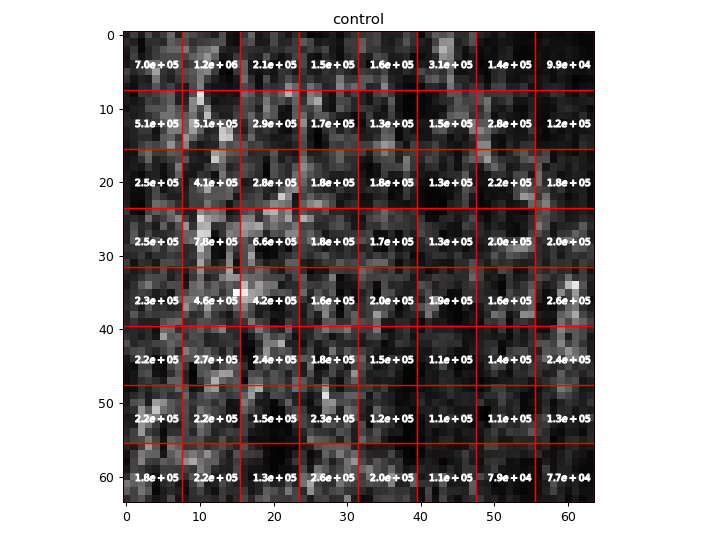

<IPython.core.display.Javascript object>


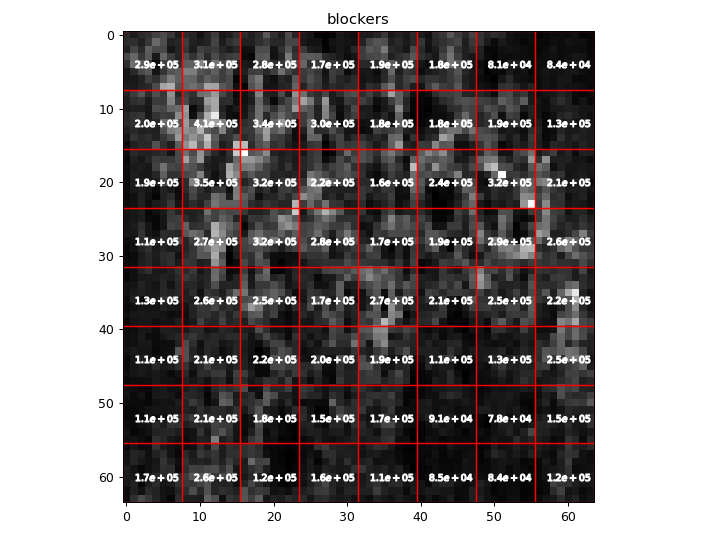

In [13]:
half_w = grid_w / 2
half_h = grid_h / 2


mode = "var" # "qse", "mean", or "var"

grid_figs = {}
for (cond, proj), locs, ms, vs in zip(
    mean_projs.items(),
    grid_locs.values(),
    grid_means.values(),
    grid_vars.values(),
):
    grid_figs[cond] = {}
    fig, ax = plt.subplots(1, figsize=(8, 6))
    grid_figs[cond]["fig"], grid_figs[cond]["ax"] = fig, ax
    ax.imshow(proj, cmap="gray")
    ax.set_title(cond)
    
    for (x, y) in locs:
        ax.add_patch(
            Rectangle(
                (x - .5, y - .5),  # grid offset
                grid_w, 
                grid_h, 
                fill=False,
                color="red",
                linewidth=1,
                linestyle="-"
            )
        )
    
    i = 0
    for y0 in range(0, y_sz, grid_h):
        for x0 in range(edge_cut, x_sz - edge_cut, grid_w):
            if mode == "qse":
                marker = "%.1e" % baseline_qses[cond][i]
            elif mode == "mean":
                marker = "%.1e" % ms[i]
            elif mode == "var":
                marker = "%.1e" % vs[i]
                
            ax.scatter(
                x0 + half_w,
                y0 + half_h, 
                marker="$%s$" % marker.lstrip("0"), 
                s=1200,
                c="1",
            )
            i += 1
            
    fig.tight_layout()

In [14]:
x = np.ones((3, 3, 1))
x = np.tile(x, (1, 1, 3))
# np.repeat(np.expand_dims(x), 2), 3, axis=2)
x.shape

(3, 3, 3)

In [15]:
np.max(stacked)

65535